In [1]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from matplotlib import pyplot as plt

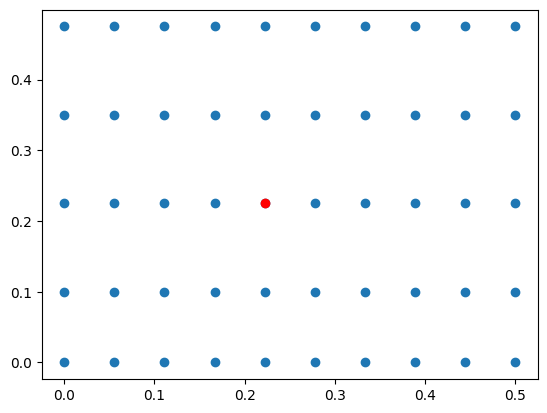

[10, 5] (50, 2)


In [41]:
nodes = 50

shape = []
loop_n = int(np.sqrt(nodes))
if loop_n**2 == nodes:
    shape = [loop_n, loop_n]
else:
    factor = []
    for i in range(1, nodes):
        if nodes % i == 0:
            factor.append(i)

    factor_ = np.flip(factor)
    for idx, f in enumerate(factor_):
        if idx+1 == len(factor_):
            continue
        next_ = factor_[idx+1]
        if f * next_ == nodes:
            shape = [f, next_]
            break

assert len(shape) == 2
km = 0.1 * shape[1]
center_x = np.ceil(shape[0] / 2)
center_y = np.ceil(shape[1] / 2)

grid = []
available_position = []
counter = 0
for row in range(1, shape[0] + 1):
    for col in range(1, shape[1] + 1):
        grid.append([row, col])
        counter += 1
        if row == center_x and col == center_y:
            continue
        available_position.append(counter)

grid = np.array(grid)
scaler = MinMaxScaler(feature_range=(0,km))
scaler.fit(grid)
grid_ = scaler.transform(grid)
[[center_x, center_y]] = scaler.transform([[center_x, center_y]])

# scale vertical size
next_ver = grid_[1]
next_hor = grid_[grid_.shape[1]]
ver_diff = next_ver[1]-grid_[0][1]
hor_diff = next_hor[0]-grid_[0][0]
if ver_diff > 0.1:
    num_diff = ver_diff-0.1
    grid_t = [[x[0], max(x[1]-num_diff, 0)] for x in grid_] 
    center_y = max(center_y-num_diff, 0)
    grid_ = np.array(grid_t)

x, y = grid_.T
plt.scatter(x,y)
plt.scatter(center_x,center_y,color='r')
plt.show()

print(shape, grid_.shape)

In [31]:
print(center_x, center_y)

0.10000000000000002 -0.15000000000000002


In [21]:
grid_

array([[0.  , 0.  ],
       [0.  , 0.2 ],
       [0.05, 0.  ],
       [0.05, 0.2 ],
       [0.1 , 0.  ],
       [0.1 , 0.2 ],
       [0.15, 0.  ],
       [0.15, 0.2 ],
       [0.2 , 0.  ],
       [0.2 , 0.2 ]])

In [6]:
import gym
import matplotlib.pyplot as plt
import numpy as np
import random
from IPython.display import clear_output

import warnings
warnings.simplefilter('ignore')

%matplotlib inline
import seaborn as sns

sns.set()

#Fixing seed for reproducibility
np.random.seed(0)

In [7]:
#Loading and rendering the gym environment
env = gym.make("Taxi-v3")
env.reset()

n_observations = env.observation_space.n
n_actions = env.action_space.n

#Initialize the Q-table to 0
Q = np.zeros((n_observations,n_actions))
print(Q)

#Getting the state space
print("Action Space {}".format(env.action_space))
print("State Space {}".format(env.observation_space))

[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 ...
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
Action Space Discrete(6)
State Space Discrete(500)


Training score over time: -1.976 7.74


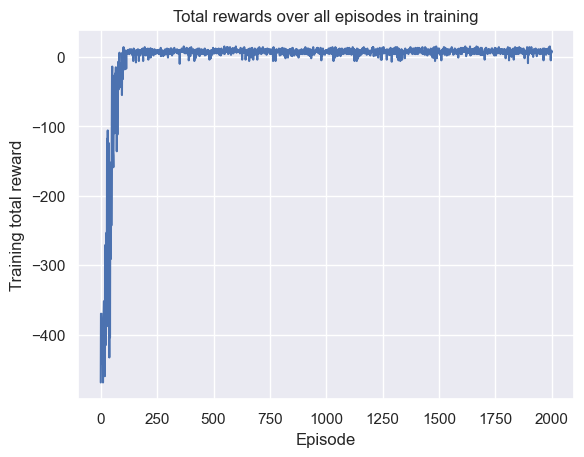

In [22]:
#Setting the hyperparameters

train_episodes = 2000   
max_steps = 100

alpha = 0.1 #learning rate                 
discount_factor = 0.9
# epsilon = 1                  
# max_epsilon = 1
# min_epsilon = 0.01         
# decay = 0.01

use_mine = True

if use_mine:
    # mine
    max_epsilon = 1
    min_epsilon = 0.01
    epsilon = max_epsilon
    decay = 0.01
    delta = (max_epsilon - min_epsilon) * decay


#Creating lists to keep track of reward and epsilon values
training_rewards = []  
epsilons = []
result_p = []
result_d = []
result_r = []

total_total_training_rewards = 0
prev_total_training_rewards = 0
for episode in range(train_episodes):
    #Reseting the environment each time as per requirement
    state, prob = env.reset()    
    #Starting the tracker for the rewards
    total_training_rewards = 0

    
    for step in range(max_steps):
        #Choosing an action given the states based on a random number
        exp_exp_tradeoff = random.uniform(0, 1) 
        
        
        ### STEP 2: SECOND option for choosing the initial action - exploit     
        #If the random number is larger than epsilon: employing exploitation 
        #and selecting best action 
        if exp_exp_tradeoff > epsilon:
            action = np.argmax(Q[state,:])
            
        ### STEP 2: FIRST option for choosing the initial action - explore       
        #Otherwise, employing exploration: choosing a random action 
        else:
            action = env.action_space.sample()
            
            
        ### STEPs 3 & 4: performing the action and getting the reward     
        #Taking the action and getting the reward and outcome state
        val = env.step(action)
        new_state, reward, done, info, prob = val

        ### STEP 5: update the Q-table
        #Updating the Q-table using the Bellman equation
        Q[state, action] = Q[state, action] + alpha * (reward + discount_factor * np.max(Q[new_state, :]) - Q[state, action]) 
        #Increasing our total reward and updating the state
        total_training_rewards += reward      
        state = new_state         
        
        #Ending the episode
        if done == True:
            #print ("Total reward for episode {}: {}".format(episode, total_training_rewards))
            break
    
    total_total_training_rewards += total_training_rewards

    if use_mine:

        p = total_total_training_rewards/(episode+1)
        diff = p

        new_epsilon = epsilon
        des = 1
        if episode > 0:
            prev_p = prev_total_training_rewards/(episode)
            diff = p - prev_p
            if diff > 0:
                des = 0
                # exploit
                new_epsilon -= delta
            else:
                # explore
                new_epsilon += delta
            result_p.append(p)
            result_d.append(des)


        new_epsilon = max(new_epsilon, min_epsilon)
        new_epsilon = min(new_epsilon, max_epsilon)
        epsilon = new_epsilon
    
    else:

        #Cutting down on exploration by reducing the epsilon 
        epsilon = min_epsilon + (max_epsilon - min_epsilon)*np.exp(-decay*episode)
    
    #Adding the total reward and reduced epsilon values
    training_rewards.append(total_training_rewards)
    result_r.append(total_total_training_rewards/(episode+1))
    epsilons.append(epsilon)

    prev_total_training_rewards = total_total_training_rewards

print ("Training score over time: " + str(sum(training_rewards)/train_episodes), np.average(training_rewards[-100:]))

#Visualizing results and total reward over all episodes
x = range(train_episodes)
plt.plot(x, training_rewards)
plt.xlabel('Episode')
plt.ylabel('Training total reward')
plt.title('Total rewards over all episodes in training') 
plt.show()

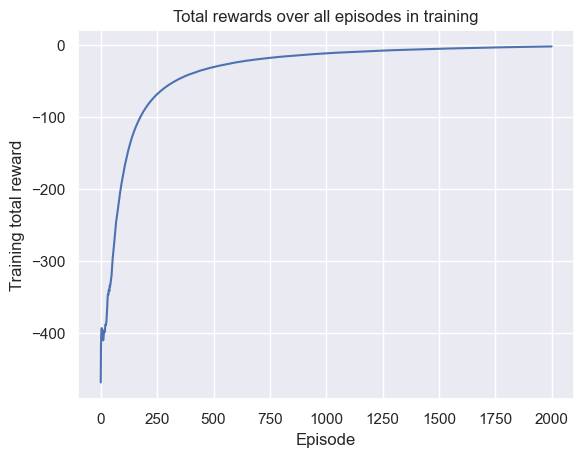

In [23]:
#Visualizing results and total reward over all episodes
x = range(train_episodes)
plt.plot(x, result_r)
plt.xlabel('Episode')
plt.ylabel('Training total reward')
plt.title('Total rewards over all episodes in training') 
plt.show()

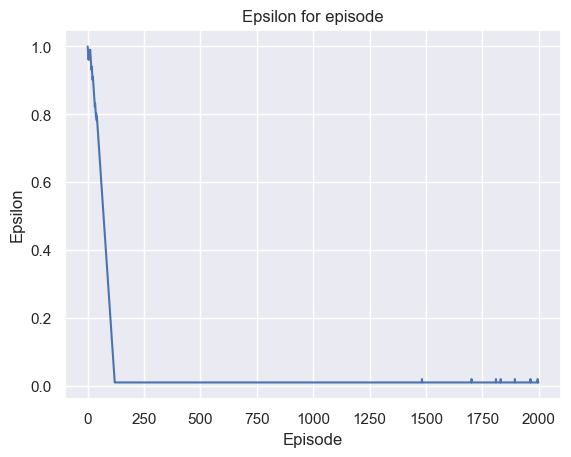

In [25]:
#Visualizing the epsilons over all episodes
plt.plot(epsilons)
plt.xlabel('Episode')
plt.ylabel('Epsilon')
plt.title("Epsilon for episode")
plt.show()

1000


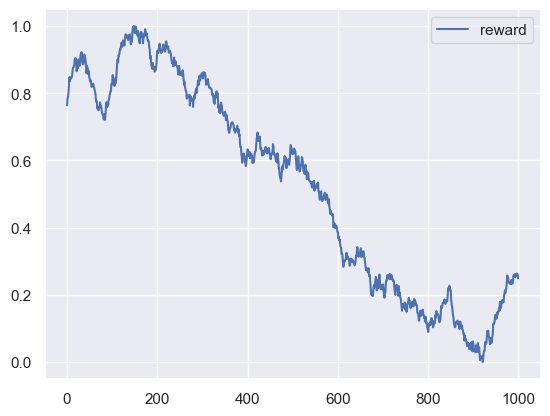

In [26]:
episodes = 1000
x = np.linspace(1, episodes, episodes)

def f(x):
    y = 0
    result = []
    for _ in x:
        result.append(y)
        y += np.random.normal(scale=1)
    return np.array(result)

def NormalizeData(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

pfree_i = NormalizeData(f(x))
print(len(pfree_i))

# log scale plot
plt.plot(pfree_i, label ='reward')
plt.legend()
plt.show()

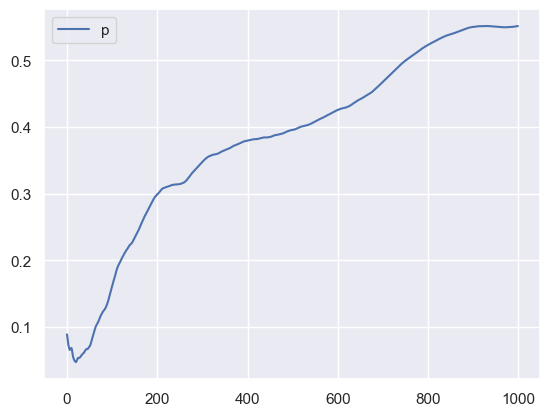

In [400]:
max_epsilon = 1
epsilon = max_epsilon
min_epsilon = 0.01
decay = 0.01
delta = (max_epsilon - min_epsilon) * decay

result_e = []
result_p = []

total_reward = 0
prev_total_reward = 0
for episode in range(episodes):
    
    reward = pfree_i[episode]
    total_reward += reward

    p = total_reward / (episode+1)
    new_epsilon = epsilon
    diff = p
    if episode > 0:
        prev_p = prev_total_reward / episode
        diff = p - prev_p
        if diff > 0:
            # exploit
            new_epsilon -= delta
        else:
            # explore
            new_epsilon += delta

    new_epsilon = max(new_epsilon, min_epsilon)
    new_epsilon = min(new_epsilon, max_epsilon)

    result_p.append(p)
    result_e.append(epsilon)

    epsilon = new_epsilon
    prev_total_reward = total_reward

# log scale plot
plt.plot(result_p, label ='p')
plt.legend()
plt.show()

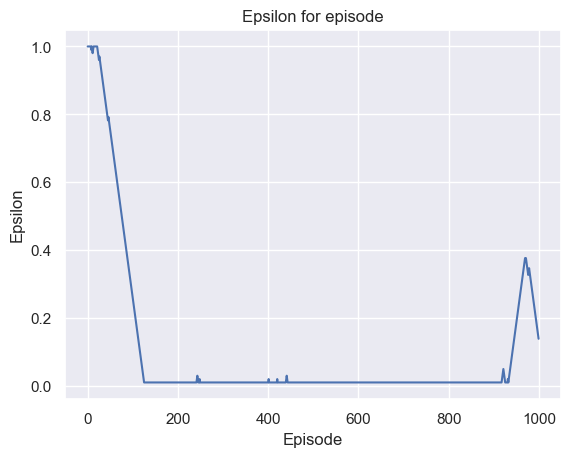

In [401]:
#Visualizing the epsilons over all episodes
plt.plot(result_e)
plt.xlabel('Episode')
plt.ylabel('Epsilon')
plt.title("Epsilon for episode")
plt.show()

In [147]:
episode = 4

epsilon = max_epsilon
decay = 0.01
min_epsilon = 0.01
new_epsilon = max(min_epsilon, np.exp(-decay*episode))

print(epsilon, new_epsilon)

1 0.9607894391523232


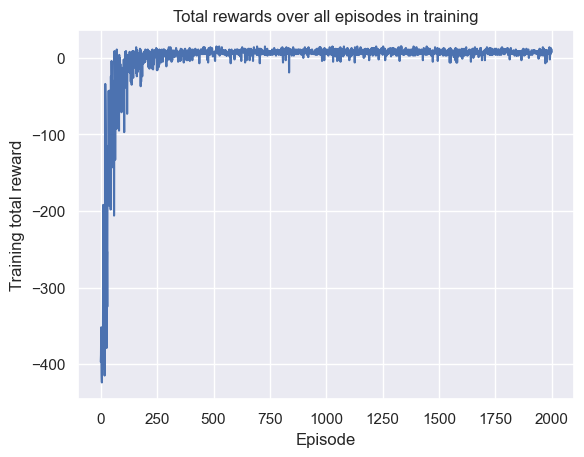

In [292]:
#Visualizing results and total reward over all episodes
x = range(train_episodes)
plt.plot(x, training_rewards)
plt.xlabel('Episode')
plt.ylabel('Training total reward')
plt.title('Total rewards over all episodes in training') 
plt.show()

In [2]:
import random
import math

app_pkPeriod = 1
app_pkPeriodVar = 0.1
diff = (app_pkPeriod*app_pkPeriodVar)
min_ = int(math.ceil((app_pkPeriod - diff) * 1000))
max_ = int(math.ceil((app_pkPeriod + diff) * 1000))
delay = random.randint(min_, max_)
print(min_, max_, delay)

900 1100 955


In [8]:
a = [54, 0, 33, 4, 2, 0]
a.reverse()
a

[0, 2, 4, 33, 0, 54]

In [32]:
src = [2, 0]
(src[0] << 8) | src[1]

512

In [25]:
(4+6)/2

5.0

In [29]:
((4 - 6) / (1 + 1))

-1.0

In [28]:
inc_mean =  6 + ((4 - 6) / (1 + 1))
inc_mean

5.0

In [27]:
import numpy as np
a = list(range(10))
cur_mean = np.mean(a)
print(cur_mean)
new_val = 5
b = a + [new_val]
expected1 = np.mean(b)
print(expected1)

inc_mean =  cur_mean + ((new_val - cur_mean) / (len(a) + 1))
print(inc_mean)

4.5
4.545454545454546
4.545454545454546


In [28]:
new_val = 15
c = b + [new_val]
expected2 = np.mean(c)
print(expected2)

inc_mean2 =  expected1 + ((new_val - expected1) / (len(b) + 1))
print(inc_mean2)

5.416666666666667
5.416666666666667


In [24]:
imin = pow(2, 10)

imax = 20
for i in range(imax+1):
    cal = imin * pow(2, i) / 1000
    if cal > 60:
        cal /= 60
        print(i, round(cal, 5), 'm')
    else:
        print(i, int(cal), 's')
    

0 1 s
1 2 s
2 4 s
3 8 s
4 16 s
5 32 s
6 1.09227 m
7 2.18453 m
8 4.36907 m
9 8.73813 m
10 17.47627 m
11 34.95253 m
12 69.90507 m
13 139.81013 m
14 279.62027 m
15 559.24053 m
16 1118.48107 m
17 2236.96213 m
18 4473.92427 m
19 8947.84853 m
20 17895.69707 m


In [3]:
lds = [0.2, 0.5, 0.8]
eps = [0.001, 0.01, 0.1]

comb = {}
for ep in eps:
    for l in lds:
        for d in lds:
            t = "{} {} {}".format(ep, l, d)
            comb[t] = 0

print(comb.keys(), print(len(comb.keys())))


27
dict_keys(['0.001 0.2 0.2', '0.001 0.2 0.5', '0.001 0.2 0.8', '0.001 0.5 0.2', '0.001 0.5 0.5', '0.001 0.5 0.8', '0.001 0.8 0.2', '0.001 0.8 0.5', '0.001 0.8 0.8', '0.01 0.2 0.2', '0.01 0.2 0.5', '0.01 0.2 0.8', '0.01 0.5 0.2', '0.01 0.5 0.5', '0.01 0.5 0.8', '0.01 0.8 0.2', '0.01 0.8 0.5', '0.01 0.8 0.8', '0.1 0.2 0.2', '0.1 0.2 0.5', '0.1 0.2 0.8', '0.1 0.5 0.2', '0.1 0.5 0.5', '0.1 0.5 0.8', '0.1 0.8 0.2', '0.1 0.8 0.5', '0.1 0.8 0.8']) None


In [83]:
import pandas as pd 

df = pd.read_csv("simulator/bin/simData/comparison_merged.csv")
df

,parameter,method,last_DIOtransmit-mean,last_DIOtransmit-std,last_DIOsurpress-mean,last_DIOsurpress-std
0,"(10, 1)",ORI,262.000000,19.000000,0.666667,0.577350
1,"(10, 1)",RIATA,146.000000,36.510273,124.000000,15.620499
2,"(10, 1)",AC,196.333333,9.865766,43.000000,9.539392
3,"(10, 1)",QT,62.666667,30.924640,154.666667,2.081666
4,"(10, 10)",ORI,103.666667,22.300972,0.333333,0.577350
5,"(10, 10)",RIATA,71.333333,20.033306,64.666667,20.816660
6,"(10, 10)",AC,85.333333,6.658328,8.666667,2.516611
7,"(10, 10)",QT,51.000000,1.000000,69.333333,10.692677
8,"(10, 5)",ORI,131.333333,8.082904,0.333333,0.577350
9,"(10, 5)",RIATA,68.000000,9.165151,72.000000,9.000000


In [84]:
df_ = df.copy()
df_

,parameter,method,last_DIOtransmit-mean,last_DIOtransmit-std,last_DIOsurpress-mean,last_DIOsurpress-std
0,"(10, 1)",ORI,262.000000,19.000000,0.666667,0.577350
1,"(10, 1)",RIATA,146.000000,36.510273,124.000000,15.620499
2,"(10, 1)",AC,196.333333,9.865766,43.000000,9.539392
3,"(10, 1)",QT,62.666667,30.924640,154.666667,2.081666
4,"(10, 10)",ORI,103.666667,22.300972,0.333333,0.577350
5,"(10, 10)",RIATA,71.333333,20.033306,64.666667,20.816660
6,"(10, 10)",AC,85.333333,6.658328,8.666667,2.516611
7,"(10, 10)",QT,51.000000,1.000000,69.333333,10.692677
8,"(10, 5)",ORI,131.333333,8.082904,0.333333,0.577350
9,"(10, 5)",RIATA,68.000000,9.165151,72.000000,9.000000


In [88]:
df_t = df_.pivot(index='parameter', columns='method', values=df_.columns[2:].to_list())
df_t = df_t.reset_index()
df_t.columns = df_t.columns.map('-'.join)
df_t

,parameter-,last_DIOtransmit-mean-AC,last_DIOtransmit-mean-ORI,last_DIOtransmit-mean-QT,last_DIOtransmit-mean-RIATA,last_DIOtransmit-std-AC,last_DIOtransmit-std-ORI,last_DIOtransmit-std-QT,last_DIOtransmit-std-RIATA,last_DIOsurpress-mean-AC,last_DIOsurpress-mean-ORI,last_DIOsurpress-mean-QT,last_DIOsurpress-mean-RIATA,last_DIOsurpress-std-AC,last_DIOsurpress-std-ORI,last_DIOsurpress-std-QT,last_DIOsurpress-std-RIATA
0,"(10, 1)",196.333333,262.000000,62.666667,146.000000,9.865766,19.000000,30.924640,36.510273,43.000000,0.666667,154.666667,124.000000,9.539392,0.577350,2.081666,15.620499
1,"(10, 10)",85.333333,103.666667,51.000000,71.333333,6.658328,22.300972,1.000000,20.033306,8.666667,0.333333,69.333333,64.666667,2.516611,0.577350,10.692677,20.816660
2,"(10, 5)",117.333333,131.333333,72.000000,68.000000,8.504901,8.082904,9.848858,9.165151,10.333333,0.333333,105.000000,72.000000,2.309401,0.577350,12.529964,9.000000
3,"(100, 1)",1864.333333,2955.333333,1331.666667,1678.000000,59.702038,15.044379,127.884062,136.495421,532.333333,44.333333,1715.666667,1428.666667,14.364308,4.932883,87.076595,125.049324
4,"(100, 10)",1119.666667,1602.333333,835.000000,970.333333,43.038742,203.591093,67.579583,39.272552,104.333333,20.666667,761.333333,729.000000,8.962886,3.511885,30.022214,11.532563
5,"(100, 5)",1352.333333,1850.333333,896.666667,1136.333333,105.191888,232.295788,84.512327,66.665833,119.333333,23.666667,1011.000000,899.333333,10.016653,6.429101,92.081486,39.576929
6,"(50, 1)",922.666667,1411.333333,552.333333,826.000000,100.380941,66.123622,80.313967,24.248711,226.000000,6.000000,847.666667,712.666667,4.582576,1.000000,38.004386,17.897858
7,"(50, 10)",531.333333,658.666667,475.666667,426.666667,11.372481,143.966431,42.193996,15.275252,52.000000,5.000000,259.666667,348.666667,3.605551,2.000000,29.501412,28.919428
8,"(50, 5)",645.666667,842.333333,376.666667,496.000000,1.527525,72.196491,21.594752,22.715633,55.666667,10.000000,448.666667,467.666667,5.131601,4.582576,15.534907,34.645827


In [89]:
df_t.to_csv('dio-transmission.csv', index=False)

In [90]:
a = "BBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBB"
len(a)

40

In [92]:
b = "B" * 10
b

'BBBBBBBBBB'